In [0]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.utils.data import DataLoader

In [0]:
DOWNLOAD_DATASET = True
BATCH_SIZE = 64
NB_TEST_IMG = 5
NB_EPOCHS = 50
DEVICE= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
norm_mean = [0.1307]
norm_std = [0.3081]

pre_process = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(
                                    mean=norm_mean,
                                    std=norm_std)])

train_data = datasets.MNIST(root='./data',
                            train=True,
                            transform=pre_process,
                            download=True)
 
train_loader = DataLoader(train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

In [0]:
class ConvolutionAutoEncoder(nn.Module):
    
    def __init__(self):
        super(ConvolutionAutoEncoder, self).__init__()
        
        # self.encoder = nn.Sequential(
        #     nn.Conv2d(1, 16, kernel_size=3, padding=1), # 16, 28, 28
        #     nn.ReLU(),
        #     nn.MaxPool2d(2), # 16, 14, 14
        #     nn.Conv2d(16, 8, kernel_size=3, padding=1), # 8, 14, 14
        #     nn.ReLU(),
        #     nn.MaxPool2d(2), # 8, 7, 7
        #     nn.Conv2d(8, 8, kernel_size=3, padding=1), # 8, 7, 7
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, stride=1) # 8, 6, 6
        # )
        # 
        # self.decoder = nn.Sequential(
        #     nn.ConvTranspose2d(8, 16, kernel_size=3, stride=1), # 16, 8, 8
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(16, 8, kernel_size=5, stride=2, padding=1), # 16, 17, 17
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(8, 1, kernel_size=2, stride=2, padding=3), # 1, 28, 28
        #     nn.Tanh()
        # )
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded

In [27]:
CAE = ConvolutionAutoEncoder()
CAE.to(DEVICE)
print(CAE)

optimizer_cae = torch.optim.Adam(CAE.parameters(), weight_decay=1e-5)
loss_func_cae = nn.MSELoss()

view_data_cae = Variable(train_data.data[:NB_TEST_IMG].view(-1, 1, 28, 28).type(torch.cuda.FloatTensor))

ConvolutionAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace)
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)


In [0]:
def plot_img(model, view_data):
    _, decoded_data = model(view_data)  
    
    f, a = plt.subplots(2, NB_TEST_IMG, figsize=(10, 4))
    
    for i in range(NB_TEST_IMG):
        a[0][i].imshow(np.reshape(view_data.cpu().data.numpy()[i],
                                   (28, 28)),
                                   cmap='gray')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    
        
    for i in range(NB_TEST_IMG):
        a[1][i].imshow(np.reshape(decoded_data.cpu().data.numpy()[i],
                                   (28, 28)),
                                   cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())

    plt.show()
    

def trainCAE(model, data_loader, view_data, loss_func, optimizer):
    for epoch in range(NB_EPOCHS):
        for x, _ in data_loader:
            x = Variable(x).to(DEVICE)
            y = Variable(x).to(DEVICE)
            
            # ===================forward=====================
            encoded, decoded = model(x)
            loss = loss_func(decoded, y)
            # ===================backward=====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(f'Epoch: {epoch}/{NB_EPOCHS} | Loss: {loss.item():.4f}')
        
        if not epoch % 5:
            plot_img(model, view_data)

Epoch: 0/100 | Loss: 0.5804


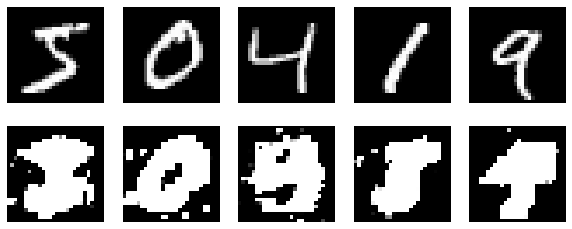

Epoch: 1/100 | Loss: 0.5151
Epoch: 2/100 | Loss: 0.4765
Epoch: 3/100 | Loss: 0.5471
Epoch: 4/100 | Loss: 0.4818
Epoch: 5/100 | Loss: 0.5197


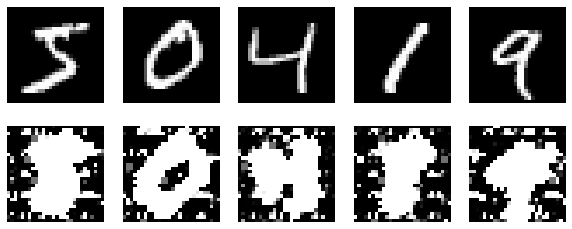

Epoch: 6/100 | Loss: 0.4994
Epoch: 7/100 | Loss: 0.5060
Epoch: 8/100 | Loss: 0.4289
Epoch: 9/100 | Loss: 0.4949
Epoch: 10/100 | Loss: 0.4558


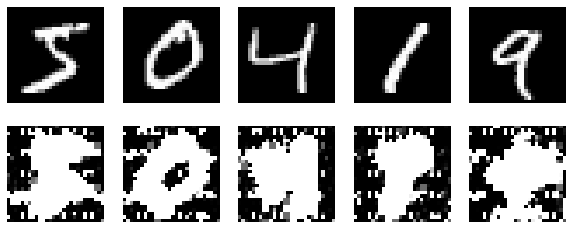

Epoch: 11/100 | Loss: 0.4469
Epoch: 12/100 | Loss: 0.4758
Epoch: 13/100 | Loss: 0.4374
Epoch: 14/100 | Loss: 0.4639
Epoch: 15/100 | Loss: 0.4529


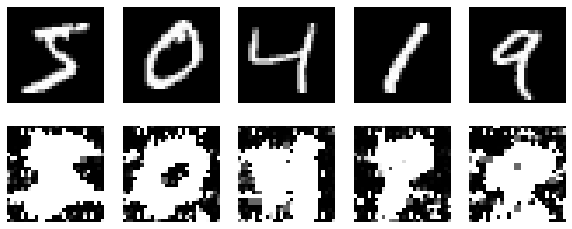

Epoch: 16/100 | Loss: 0.4088
Epoch: 17/100 | Loss: 0.4288
Epoch: 18/100 | Loss: 0.4143
Epoch: 19/100 | Loss: 0.4472
Epoch: 20/100 | Loss: 0.3993


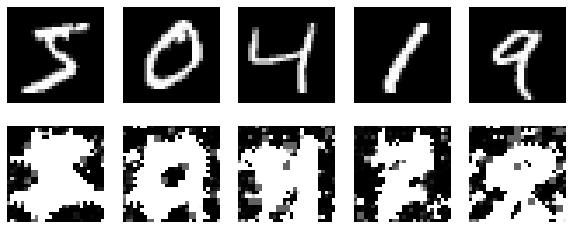

Epoch: 21/100 | Loss: 0.4385
Epoch: 22/100 | Loss: 0.4497
Epoch: 23/100 | Loss: 0.4685
Epoch: 24/100 | Loss: 0.4669
Epoch: 25/100 | Loss: 0.4189


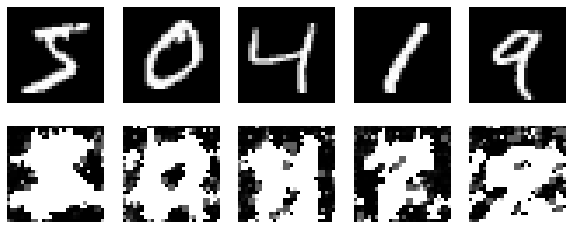

Epoch: 26/100 | Loss: 0.4406
Epoch: 27/100 | Loss: 0.4277
Epoch: 28/100 | Loss: 0.4442
Epoch: 29/100 | Loss: 0.4410
Epoch: 30/100 | Loss: 0.4743


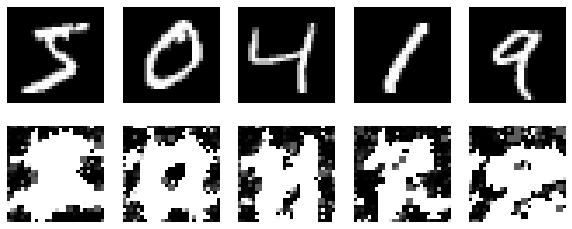

Epoch: 31/100 | Loss: 0.4408
Epoch: 32/100 | Loss: 0.4257
Epoch: 33/100 | Loss: 0.4480
Epoch: 34/100 | Loss: 0.4238
Epoch: 35/100 | Loss: 0.4455


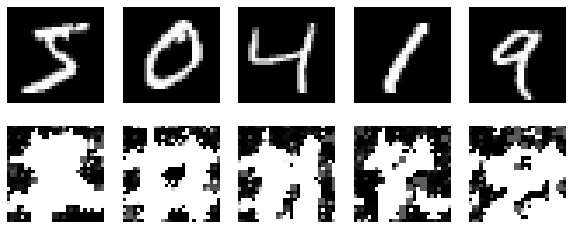

Epoch: 36/100 | Loss: 0.4360
Epoch: 37/100 | Loss: 0.4410
Epoch: 38/100 | Loss: 0.4277
Epoch: 39/100 | Loss: 0.4646
Epoch: 40/100 | Loss: 0.4242


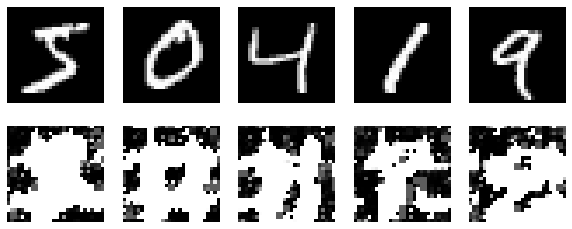

Epoch: 41/100 | Loss: 0.4688
Epoch: 42/100 | Loss: 0.4211
Epoch: 43/100 | Loss: 0.5005
Epoch: 44/100 | Loss: 0.4700
Epoch: 45/100 | Loss: 0.4360


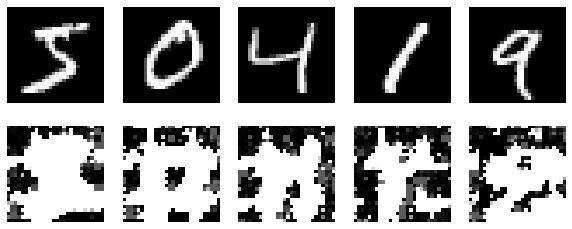

Epoch: 46/100 | Loss: 0.4537
Epoch: 47/100 | Loss: 0.3855
Epoch: 48/100 | Loss: 0.4239
Epoch: 49/100 | Loss: 0.4239
Epoch: 50/100 | Loss: 0.4759


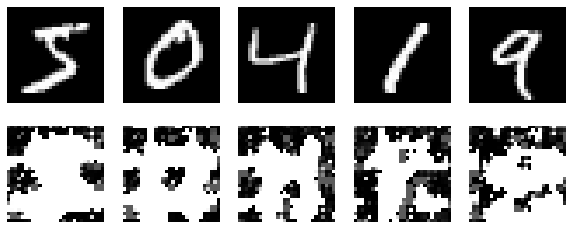

Epoch: 51/100 | Loss: 0.4357
Epoch: 52/100 | Loss: 0.4104
Epoch: 53/100 | Loss: 0.4888
Epoch: 54/100 | Loss: 0.4420
Epoch: 55/100 | Loss: 0.4018


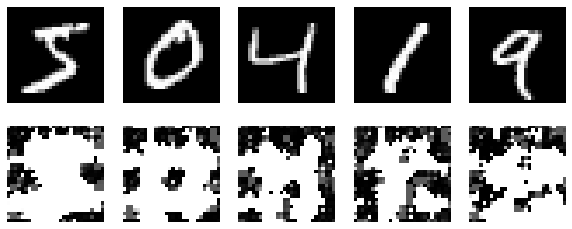

Epoch: 56/100 | Loss: 0.4229
Epoch: 57/100 | Loss: 0.4751
Epoch: 58/100 | Loss: 0.4428
Epoch: 59/100 | Loss: 0.4813
Epoch: 60/100 | Loss: 0.4101


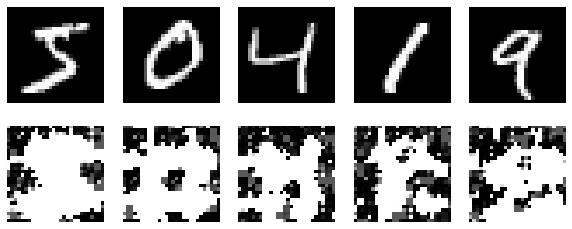

Epoch: 61/100 | Loss: 0.4044
Epoch: 62/100 | Loss: 0.4120
Epoch: 63/100 | Loss: 0.4227
Epoch: 64/100 | Loss: 0.4811
Epoch: 65/100 | Loss: 0.4044


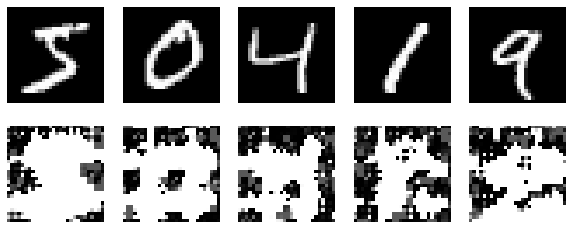

Epoch: 66/100 | Loss: 0.4437
Epoch: 67/100 | Loss: 0.3705
Epoch: 68/100 | Loss: 0.4282
Epoch: 69/100 | Loss: 0.4869
Epoch: 70/100 | Loss: 0.4475


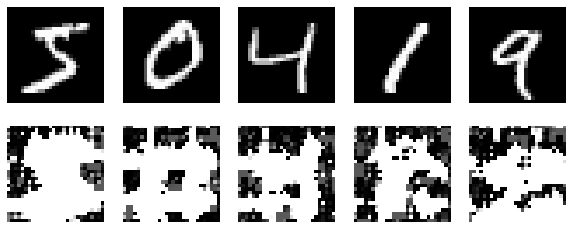

Epoch: 71/100 | Loss: 0.4400
Epoch: 72/100 | Loss: 0.4223
Epoch: 73/100 | Loss: 0.4132
Epoch: 74/100 | Loss: 0.4404
Epoch: 75/100 | Loss: 0.4164


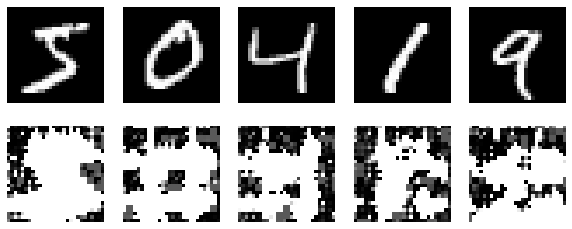

Epoch: 76/100 | Loss: 0.4115
Epoch: 77/100 | Loss: 0.4208
Epoch: 78/100 | Loss: 0.4286
Epoch: 79/100 | Loss: 0.4230
Epoch: 80/100 | Loss: 0.4280


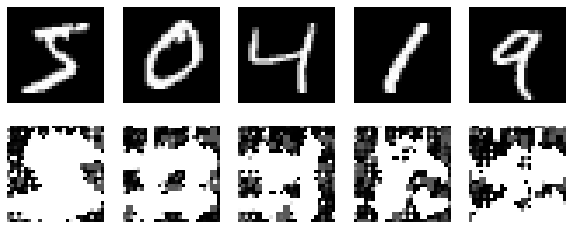

Epoch: 81/100 | Loss: 0.3995
Epoch: 82/100 | Loss: 0.4382
Epoch: 83/100 | Loss: 0.4245
Epoch: 84/100 | Loss: 0.3915
Epoch: 85/100 | Loss: 0.4327


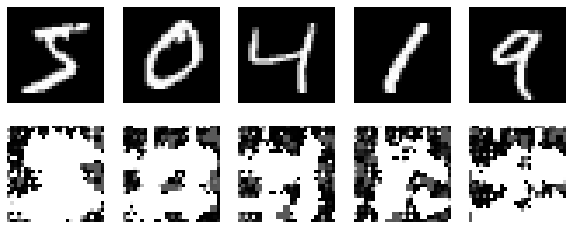

Epoch: 86/100 | Loss: 0.4450
Epoch: 87/100 | Loss: 0.4105


KeyboardInterrupt: ignored

In [29]:
trainCAE(CAE, train_loader, view_data_cae, loss_func_cae, optimizer_cae)

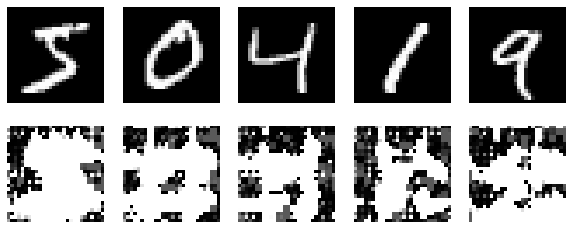

In [30]:
plot_img(CAE, view_data_cae)